In [6]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
from nltk.tokenize import word_tokenize, sent_tokenize
import plotly.express as px
from plotly.offline import iplot

import os
import cv2
import argparse
import numpy as np
import pandas as pd
import glob
from PIL import Image
import datetime
import matplotlib.pyplot as plt

from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.callbacks import Callback
from keras.backend import clear_session
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import resnet50, mobilenet, xception
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# data_path = "/content/drive/MyDrive/gproject/Food Images/Food Images"
images_fl = '/content/drive/MyDrive/gproject/Food Images/Food Images'

In [10]:
image_files = os.listdir(images_fl)
image_file_set= set(image_files)

In [9]:
df = pd.read_csv('/content/drive/MyDrive/gproject/Food Ingredients and Recipe Dataset with Image Name Mapping.csv')

In [11]:
# df

In [12]:
df = df.dropna(subset=['Image_Name'])

In [10]:
# df

In [13]:
df['Image_Name'] = df['Image_Name'].str.strip().str.lower()

In [14]:
df['Image_Name'] = df['Image_Name'].apply(lambda x: x + '.jpg' if not x.endswith(('.jpg', '.png')) else x)

df['Image_Path'] = df['Image_Name'].apply(lambda x: os.path.join(images_fl, x))
image_file_set = {f for f in os.listdir(images_fl) if f.lower().endswith(('.jpg', '.png'))}
df['Valid_Image'] = df['Image_Name'].isin(image_file_set)
valid_df = df[df['Valid_Image']].copy()


# List any missing images
missing_images = df[~df['Valid_Image']]['Image_Name'].unique()


valid_df['Ingredients'] = valid_df['Ingredients'].apply(lambda x: [i.strip() for i in x.split(',')])

# Create a sorted list of unique ingredients
valid_ingredients_list = sorted(list({ingredient for row in valid_df['Ingredients'] for ingredient in row}))

# Number of unique ingredients
NUM_INGREDIENTS = len(valid_ingredients_list)
print(NUM_INGREDIENTS)

#  a mapping from ingredient to index
ingredient_to_index = {ingredient: id1 for id1, ingredient in enumerate(valid_ingredients_list)}


# print(valid_df.head())

83223


In [15]:
valid_df = valid_df[valid_df['Image_Name'] != '#name?.jpg']

In [16]:
# valid_df

In [17]:
df = df.drop(df.columns[0], axis=1)

In [18]:
print(df['Image_Name'].dtype)
print(df['Image_Name'].isnull().sum())
# print(df['Image_Name'].isnull().sum())
missing_extensions = df[~df['Image_Name'].str.endswith(('.jpg'))]
# print(missing_extensions)
df['Image_Name'] = df['Image_Name'].str.strip().str.lower()
df = df.drop(df.columns[0], axis=1)
# df

object
0


In [19]:
# fixing mising extensio
df['Image_Name'] = df['Image_Name'].apply(lambda x: x + '.jpg' if not x.endswith(('.jpg', '.png')) else x)

In [20]:
dataset_images = set(df['Image_Name'])
missing_images = dataset_images - image_file_set
if missing_images:
    print(f"Missing images: {missing_images}")
else:
    print("No missing images.")
valid_df = df[df['Image_Name'].isin(image_file_set)]
print(f"Number of valid rows: {len(valid_df)}")

# # Use `valid_df` for dataset creation
# dataset = create_dataset(valid_df)

Missing images: {'#name?.jpg'}
Number of valid rows: 13471


In [21]:
from PIL import UnidentifiedImageError
import tensorflow as tf

def data_generator(df):
    for _,row in df.iterrows():
        try:
            image =row['image']
            label =row['encoded_ingredients']
            yield image, label
        except (UnidentifiedImageError, Exception) as e:
            print(e)

In [22]:
valid_df['Image_Name'][1]

'crispy-salt-and-pepper-potatoes-dan-kluger.jpg'

In [23]:
df['Ingredients'] = df['Ingredients'].apply(lambda x: x.split(','))
valid_ingredients_list = sorted(list({Ingredient.strip() for row in df['Ingredients'] for Ingredient in row}))
NUM_INGREDIENTS = len(valid_ingredients_list)

In [ ]:
NUM_INGREDIENTS

83374

In [24]:
# Ingredient to index mapping
ingredient_to_index ={Ingredient: idx for idx, Ingredient in enumerate(valid_ingredients_list)}
# ingredient_to_index

In [25]:
def encode_ingredients(ingredients):
    encoded = [0] * NUM_INGREDIENTS
    for ingredient in ingredients:
        if ingredient in ingredient_to_index:
            encoded[ingredient_to_index[ingredient]] = 1
    return encoded




In [26]:
# Preprocessing
img_size = 224
Chnnls = 3

def preprocess_image(image_path):
    image= tf.io.read_file(image_path)
    image= tf.image.decode_jpeg(image, channels=3)
    image= tf.image.resize(image, [img_size,img_size])
    image= image /255.0
    return image


In [27]:
def preprocess_data(row, index=None):
    image_name = row['Image_Name']
    if image_name in image_file_set:

        image_path = os.path.join(images_fl, image_name)
        image =preprocess_image(image_path)
    else:
        image = tf.zeros((img_size, img_size, 3))

    # Convert ingredients to a tensor
    ingredients = tf.convert_to_tensor(row['encoded_ingredients'], dtype=tf.float32)
    return image,ingredients

In [28]:
def data_generator(df):
    for _, row in df.iterrows():
        try:
            image = tf.io.read_file(row['Image_Path'])
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [img_size,img_size])
            label = row['encoded_ingredients']
            yield image, label
        except Exception as e:
            print(e)


In [29]:
img_size = 224
NUM_INGREDIENTS = 83374
BATCH_SIZE = 8
EPOCHS = 5
ACTI = "relu"
channels=3

In [30]:
from sklearn.model_selection import train_test_split
def create_dataset(df):

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(df),
        output_signature=(
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(NUM_INGREDIENTS,), dtype=tf.float32)
        )
    )
    return dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_df, val_df = train_test_split(valid_df, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)


# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_size, img_size, 3)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(NUM_INGREDIENTS, activation='sigmoid')
])
model.add(tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_size, img_size, channels)))


# Resize and rescale layer
resize_and_rescale = tf.keras.layers.Rescaling(1.0 / 255)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

model.add(resize_and_rescale)
model.add(data_augmentation)


In [ ]:
valid_image_paths = []

def validate_images(df):
    for _, row in df.iterrows():
        try:
            image = tf.io.read_file(row['Image_Path'])
            image = tf.image.decode_jpeg(image, channels=3)
            valid_image_paths.append(row['Image_Path'])
        except:
            print(f"Invalid image: {row['Image_Path']}")

validate_images(valid_df)

valid_df= valid_df[valid_df['Image_Path'].isin(valid_image_paths)]

# Create TensorFlow datasets
train_df, val_df = train_test_split(valid_df, test_size=0.2, random_state=42)
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_size, img_size, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_INGREDIENTS, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
# history = model.fit(train_dataset, epochs=2, validation_data=val_dataset)

Invalid image: /content/drive/MyDrive/gproject/Food Images/Food Images/la-pina-cocktail-mezcal-pineapple.jpg
Invalid image: /content/drive/MyDrive/gproject/Food Images/Food Images/arinato-cocktail-ivy-mix.jpg


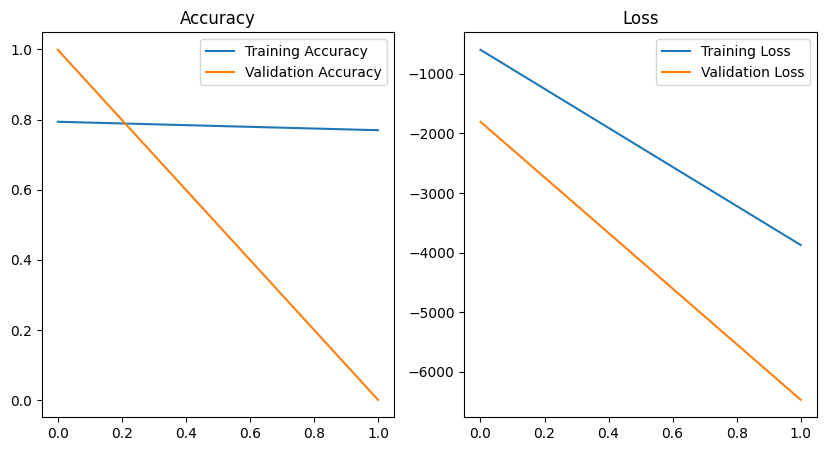

In [ ]:
# Analyze training history
import matplotlib.pyplot as plt

# Plot training accuracy and loss
plt.figure(figsize=(10, 5))

# Training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 83374), dtype=tf.float32, name=None))>